<a href="https://colab.research.google.com/github/CodeSage54/Machine-Learning/blob/main/Covid_TimeSeries_Analysis/Covid19_Analysis_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Problem Statement:**
Given data about COVID-19 patients, write code to visualize the impact and
analyze the trend of rate of infection and recovery as well as make predictions
about the number of cases expected a week in future based on the current
trends.

**Dataset:**
CSV and Excel files containing data about the number of COVID-19 confirmed
deaths and recovered patients both around the world and in India.

**Guidelines:**

● Use pandas to accumulate data from multiple data files.

● Use plotly (visualization library) to create interactive visualizations.

● Use Facebook prophet library to make time series models.

● Visualize the prediction by combining these technologies.

**Expand the sections below to view the code and run results.**

In [223]:
# Intalling prophet
!pip install prophet

# Load and Analyse data - EDA

In [224]:
# Importing necessary Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# import plotly for visualizations
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# import Prophet for timeseries forecasting
from prophet import Prophet

import warnings
warnings.filterwarnings('ignore')  # to help remove warning statments along with output

In [225]:
# Reading dataset
df_covid = pd.read_csv('/content/covid_19_clean_complete.csv', index_col = 'Date', parse_dates = ['Date'] )
df_covid.head()

,Province/State,Country/Region,Lat,Long,Confirmed,Deaths,Recovered,Active,WHO Region
Date,,,,,,,,,
2020-01-22,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,Eastern Mediterranean
2020-01-22,NaN,Albania,41.15330,20.168300,0,0,0,0,Europe
2020-01-22,NaN,Algeria,28.03390,1.659600,0,0,0,0,Africa
2020-01-22,NaN,Andorra,42.50630,1.521800,0,0,0,0,Europe
2020-01-22,NaN,Angola,-11.20270,17.873900,0,0,0,0,Africa


In [226]:
#check the number of rows
df_covid.shape

(49068, 9)

In [227]:
df_covid.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49068 entries, 2020-01-22 to 2020-07-27
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Province/State  14664 non-null  object 
 1   Country/Region  49068 non-null  object 
 2   Lat             49068 non-null  float64
 3   Long            49068 non-null  float64
 4   Confirmed       49068 non-null  int64  
 5   Deaths          49068 non-null  int64  
 6   Recovered       49068 non-null  int64  
 7   Active          49068 non-null  int64  
 8   WHO Region      49068 non-null  object 
dtypes: float64(2), int64(4), object(3)
memory usage: 3.7+ MB


In [228]:
df_covid.isnull().sum()

,0
Province/State,34404
Country/Region,0
Lat,0
Long,0
Confirmed,0
Deaths,0
Recovered,0
Active,0
WHO Region,0


34404 rows of province are null but we can ignore it for now and consider country_region for further Analysis and forecasting.

In [229]:
# Rename all the columns
df_covid.rename(columns = {'Province/State':'province_state','Country/Region': 'country', 'Lat':'lat','Long':'long','Confirmed':'confirmed',
                           'Deaths':'deaths','Recovered':'recovered','Active':'active','WHO Region':'who_region' }, inplace = True)
df_covid.head()

,province_state,country,lat,long,confirmed,deaths,recovered,active,who_region
Date,,,,,,,,,
2020-01-22,NaN,Afghanistan,33.93911,67.709953,0,0,0,0,Eastern Mediterranean
2020-01-22,NaN,Albania,41.15330,20.168300,0,0,0,0,Europe
2020-01-22,NaN,Algeria,28.03390,1.659600,0,0,0,0,Africa
2020-01-22,NaN,Andorra,42.50630,1.521800,0,0,0,0,Europe
2020-01-22,NaN,Angola,-11.20270,17.873900,0,0,0,0,Africa


In [230]:
#Find Max and min of Date

print(f"Dataset contains data for the period {df_covid.index.min()} to {df_covid.index.max()}")


Dataset contains data for the period 2020-01-22 00:00:00 to 2020-07-27 00:00:00


We have daily data from 22 Jan 2020 to 27 July 2020.
Lets see how many distinct countries / region are present.  

In [231]:
#get distinct Date values
df_covid.index.nunique()

188

In [232]:
# get distinct country values
df_covid.country.nunique()

187

In [233]:
# poulating rows with max date in top
top = df_covid[df_covid.index == '2020-07-27']
top

,province_state,country,lat,long,confirmed,deaths,recovered,active,who_region
Date,,,,,,,,,
2020-07-27,NaN,Afghanistan,33.939110,67.709953,36263,1269,25198,9796,Eastern Mediterranean
2020-07-27,NaN,Albania,41.153300,20.168300,4880,144,2745,1991,Europe
2020-07-27,NaN,Algeria,28.033900,1.659600,27973,1163,18837,7973,Africa
2020-07-27,NaN,Andorra,42.506300,1.521800,907,52,803,52,Europe
2020-07-27,NaN,Angola,-11.202700,17.873900,950,41,242,667,Africa
...,...,...,...,...,...,...,...,...,...
2020-07-27,NaN,Sao Tome and Principe,0.186400,6.613100,865,14,734,117,Africa
2020-07-27,NaN,Yemen,15.552727,48.516388,1691,483,833,375,Eastern Mediterranean
2020-07-27,NaN,Comoros,-11.645500,43.333300,354,7,328,19,Africa


In [234]:
# Grouping all top date rows based  on country (for max date = 27 July 2020 )
top.groupby(by='country')[['confirmed', 'deaths', 'recovered', 'active']].sum().reset_index()

,country,confirmed,deaths,recovered,active
0,Afghanistan,36263,1269,25198,9796
1,Albania,4880,144,2745,1991
2,Algeria,27973,1163,18837,7973
3,Andorra,907,52,803,52
4,Angola,950,41,242,667
...,...,...,...,...,...
182,West Bank and Gaza,10621,78,3752,6791
183,Western Sahara,10,1,8,1
184,Yemen,1691,483,833,375
185,Zambia,4552,140,2815,1597


# Worldwide trend Analysis - confirmed, active, deaths

In [235]:
# Populating worldwide confirmed cases Datewise
df_confirmed = df_covid.groupby(by='Date')['confirmed'].sum().reset_index()
df_confirmed

,Date,confirmed
0,2020-01-22,555
1,2020-01-23,654
2,2020-01-24,941
3,2020-01-25,1434
4,2020-01-26,2118
...,...,...
183,2020-07-23,15510481
184,2020-07-24,15791645
185,2020-07-25,16047190
186,2020-07-26,16251796


**World wide Confirmed cases Trend**

In [236]:
# Visualize worldwide confirmed cases using plotly
fig = px.line(df_confirmed, x='Date', y='confirmed', title='Worldwide Confirmed Cases Trend')
fig.show()

**Top 10 countries with most Deaths**

In [237]:

df_top_10_deaths = df_covid.groupby(by='country')['deaths'].sum().sort_values(ascending = False).head(10).reset_index()
df_top_10_deaths

,country,deaths
0,US,11011411
1,United Kingdom,3997775
2,Brazil,3938034
3,Italy,3707717
4,France,3048524
5,Spain,3033030
6,Mexico,1728277
7,India,1111831
8,Iran,1024136
9,Belgium,963679


In [238]:
# Plot top 10 countries with most number of deaths in a barchart
fig = px.bar(df_top_10_deaths, x='country', y='deaths', title='Top 10 Countries with Most Deaths')
fig.show()

**Top 10 countries with most Recovered Cases.**

In [239]:
df_top_10_recovered = df_covid.groupby(by='country')['recovered'].sum().sort_values(ascending = False).head(10).reset_index()
df_top_10_recovered

,country,recovered
0,US,56353416
1,Brazil,54492873
2,Russia,25120448
3,India,23783720
4,Germany,17107839
5,Italy,15673910
6,Iran,15200895
7,Spain,15093583
8,Turkey,13345389
9,Chile,13292593


In [240]:
# Plot Top 10 countries with most Recovered Cases.
fig = px.bar(df_top_10_recovered, x='country', y='recovered', title="Top 10 countries with most Recovered Cases.")
fig.show()

**Top 10 countries with most active cases**

In [241]:
df_top_10_active = df_covid.groupby(by='country')['active'].sum().sort_values(ascending = False).head(10).reset_index()
df_top_10_active

,country,active
0,US,156981121
1,Brazil,31094060
2,United Kingdom,22624595
3,Russia,19668578
4,India,15987913
5,France,10980287
6,Spain,9277432
7,Canada,8656985
8,Peru,7748957
9,Italy,7363518


In [242]:
# Plot Top 10 countries with most Active Cases.
fig = px.bar(df_top_10_active, x='country', y='active', title="Top 10 countries with most Active Cases.")
fig.show()

# Country Wise Analysis. We will take 3 countries - USA, China and India

In [243]:
# Creating US dataset which will have country as US
df_US = df_covid[df_covid['country'] == 'US']
df_US.head()


,province_state,country,lat,long,confirmed,deaths,recovered,active,who_region
Date,,,,,,,,,
2020-01-22,NaN,US,40.0,-100.0,1,0,0,1,Americas
2020-01-23,NaN,US,40.0,-100.0,1,0,0,1,Americas
2020-01-24,NaN,US,40.0,-100.0,2,0,0,2,Americas
2020-01-25,NaN,US,40.0,-100.0,2,0,0,2,Americas
2020-01-26,NaN,US,40.0,-100.0,5,0,0,5,Americas


In [244]:
# Creating China dataset which will have country as China
df_China = df_covid[df_covid['country'] == 'China']
df_China.head()


,province_state,country,lat,long,confirmed,deaths,recovered,active,who_region
Date,,,,,,,,,
2020-01-22,Anhui,China,31.8257,117.2264,1,0,0,1,Western Pacific
2020-01-22,Beijing,China,40.1824,116.4142,14,0,0,14,Western Pacific
2020-01-22,Chongqing,China,30.0572,107.8740,6,0,0,6,Western Pacific
2020-01-22,Fujian,China,26.0789,117.9874,1,0,0,1,Western Pacific
2020-01-22,Gansu,China,35.7518,104.2861,0,0,0,0,Western Pacific


In [245]:
# Creating India dataset which will have country as India
df_India = df_covid[df_covid['country'] == 'India']
df_India.head()


,province_state,country,lat,long,confirmed,deaths,recovered,active,who_region
Date,,,,,,,,,
2020-01-22,NaN,India,20.593684,78.96288,0,0,0,0,South-East Asia
2020-01-23,NaN,India,20.593684,78.96288,0,0,0,0,South-East Asia
2020-01-24,NaN,India,20.593684,78.96288,0,0,0,0,South-East Asia
2020-01-25,NaN,India,20.593684,78.96288,0,0,0,0,South-East Asia
2020-01-26,NaN,India,20.593684,78.96288,0,0,0,0,South-East Asia


**Aggregating sum of confirmed, active and deaths for these countries below**

In [246]:
df_US = df_US.groupby(by='Date')[['confirmed', 'deaths', 'recovered', 'active']].sum().reset_index()
df_US

,Date,confirmed,deaths,recovered,active
0,2020-01-22,1,0,0,1
1,2020-01-23,1,0,0,1
2,2020-01-24,2,0,0,2
3,2020-01-25,2,0,0,2
4,2020-01-26,5,0,0,5
...,...,...,...,...,...
183,2020-07-23,4038816,144430,1233269,2661117
184,2020-07-24,4112531,145560,1261624,2705347
185,2020-07-25,4178970,146465,1279414,2753091
186,2020-07-26,4233923,146935,1297863,2789125


In [247]:
df_China = df_China.groupby(by='Date')[['confirmed', 'deaths', 'recovered', 'active']].sum().reset_index()
df_China

,Date,confirmed,deaths,recovered,active
0,2020-01-22,548,17,28,503
1,2020-01-23,643,18,30,595
2,2020-01-24,920,26,36,858
3,2020-01-25,1406,42,39,1325
4,2020-01-26,2075,56,49,1970
...,...,...,...,...,...
183,2020-07-23,86045,4649,78701,2695
184,2020-07-24,86202,4650,78745,2807
185,2020-07-25,86381,4652,78813,2916
186,2020-07-26,86570,4652,78862,3056


In [248]:
df_India = df_India.groupby(by='Date')[['confirmed', 'deaths', 'recovered', 'active']].sum().reset_index()
df_India

,Date,confirmed,deaths,recovered,active
0,2020-01-22,0,0,0,0
1,2020-01-23,0,0,0,0
2,2020-01-24,0,0,0,0
3,2020-01-25,0,0,0,0
4,2020-01-26,0,0,0,0
...,...,...,...,...,...
183,2020-07-23,1288108,30601,817209,440298
184,2020-07-24,1337024,31358,849432,456234
185,2020-07-25,1385635,32060,885573,468002
186,2020-07-26,1435616,32771,917568,485277


**Plot and Compare these countries based on Recovered cases.**

In [249]:
# Plot a line chart using Plotly for comparing recovered cases in all three countries

# Create figure
fig = go.Figure()

# Add US line
fig.add_trace(go.Scatter(x=df_US['Date'], y=df_US['recovered'],
                         mode='lines', name='US'))

# Add China line
fig.add_trace(go.Scatter(x=df_China['Date'], y=df_China['recovered'],
                         mode='lines', name='China'))

# Add India line
fig.add_trace(go.Scatter(x=df_India['Date'], y=df_India['recovered'],
                         mode='lines', name='India'))

# Customize layout
fig.update_layout(title="COVID-19 Recovered Cases Trend - US, China, India",
                  xaxis_title="Date",
                  yaxis_title="Recovered Cases")

fig.show()


**Plot and compare these countries based on deaths**

In [250]:
# Create figure
fig = go.Figure()
# Add US line
fig.add_trace(go.Scatter(x=df_US['Date'], y=df_US['deaths'],
                         mode='lines', name='US'))
# Add China line
fig.add_trace(go.Scatter(x=df_China['Date'], y=df_China['deaths'],
                         mode='lines', name='China'))
# Add India line
fig.add_trace(go.Scatter(x=df_India['Date'], y=df_India['deaths'],
                         mode='lines', name='India'))
# Customize layout
fig.update_layout(title="COVID-19 Deaths Cases Trend - US, China, India",
                  xaxis_title="Date",
                  yaxis_title="Death Cases")

fig.show()

**Plot and compare these countries based on Active cases**

In [251]:
# Create figure
fig = go.Figure()
# Add US line
fig.add_trace(go.Scatter(x=df_US['Date'], y=df_US['active'],
                         mode='lines', name='US'))
# Add China line
fig.add_trace(go.Scatter(x=df_China['Date'], y=df_China['active'],
                         mode='lines', name='China'))
# Add India line
fig.add_trace(go.Scatter(x=df_India['Date'], y=df_India['active'],
                         mode='lines', name='India'))
# Customize layout
fig.update_layout(title="COVID-19 Active Cases Trend - US, China, India",
                  xaxis_title="Date",
                  yaxis_title="Active Cases")

fig.show()

# Modelling - Worlwide forecasts for recovered, confirmed, active and death cases

In [252]:
# Populating worldwide confirmed cases Datewise
df_confirmed = df_covid.groupby(by='Date')['confirmed'].sum().reset_index()
df_confirmed

,Date,confirmed
0,2020-01-22,555
1,2020-01-23,654
2,2020-01-24,941
3,2020-01-25,1434
4,2020-01-26,2118
...,...,...
183,2020-07-23,15510481
184,2020-07-24,15791645
185,2020-07-25,16047190
186,2020-07-26,16251796


In [253]:
# Populating worldwide recovered cases Datewise
df_recovered = df_covid.groupby(by='Date')['recovered'].sum().reset_index()
df_recovered

,Date,recovered
0,2020-01-22,28
1,2020-01-23,30
2,2020-01-24,36
3,2020-01-25,39
4,2020-01-26,52
...,...,...
183,2020-07-23,8710969
184,2020-07-24,8939705
185,2020-07-25,9158743
186,2020-07-26,9293464


In [254]:
# Populating worldwide active cases Datewise
df_active = df_covid.groupby(by='Date')['active'].sum().reset_index()
df_active

,Date,active
0,2020-01-22,510
1,2020-01-23,606
2,2020-01-24,879
3,2020-01-25,1353
4,2020-01-26,2010
...,...,...
183,2020-07-23,6166006
184,2020-07-24,6212290
185,2020-07-25,6243930
186,2020-07-26,6309711


In [255]:
# Populating worldwide death cases Datewise
df_deaths = df_covid.groupby(by='Date')['deaths'].sum().reset_index()
df_deaths

,Date,deaths
0,2020-01-22,17
1,2020-01-23,18
2,2020-01-24,26
3,2020-01-25,42
4,2020-01-26,56
...,...,...
183,2020-07-23,633506
184,2020-07-24,639650
185,2020-07-25,644517
186,2020-07-26,648621


In [256]:
# For Prophet, the date column should be renamed as ds and the target column should be renamed to y
df_confirmed.rename(columns = {'Date':'ds', 'confirmed':'y'}, inplace = True)
df_recovered.rename(columns = {'Date':'ds', 'recovered':'y'}, inplace = True)
df_active.rename(columns = {'Date':'ds', 'active':'y'}, inplace = True)
df_deaths.rename(columns = {'Date':'ds', 'deaths':'y'}, inplace = True)

In [257]:
#Create a model for forecasting confirmed cases
model = Prophet()
model.fit(df_confirmed)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [258]:
# Making prediction for next 7 dates
future = model.make_future_dataframe(periods=7)

forecast = model.predict(future)
forecast.tail(9)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
186,2020-07-26,1.592907e+07,1.582700e+07,1.604404e+07,1.592907e+07,1.592907e+07,7298.791978,7298.791978,7298.791978,7298.791978,7298.791978,7298.791978,0.0,0.0,0.0,1.593637e+07
187,2020-07-27,1.613306e+07,1.602600e+07,1.622962e+07,1.613306e+07,1.613306e+07,-2102.755455,-2102.755455,-2102.755455,-2102.755455,-2102.755455,-2102.755455,0.0,0.0,0.0,1.613096e+07
188,2020-07-28,1.633705e+07,1.620920e+07,1.641945e+07,1.633705e+07,1.633705e+07,-16846.239961,-16846.239961,-16846.239961,-16846.239961,-16846.239961,-16846.239961,0.0,0.0,0.0,1.632021e+07
189,2020-07-29,1.654104e+07,1.642102e+07,1.663180e+07,1.653811e+07,1.654247e+07,-11063.558307,-11063.558307,-11063.558307,-11063.558307,-11063.558307,-11063.558307,0.0,0.0,0.0,1.652998e+07
190,2020-07-30,1.674503e+07,1.664734e+07,1.685067e+07,1.673745e+07,1.675060e+07,-1117.543863,-1117.543863,-1117.543863,-1117.543863,-1117.543863,-1117.543863,0.0,0.0,0.0,1.674392e+07
191,2020-07-31,1.694902e+07,1.685009e+07,1.706856e+07,1.693488e+07,1.696056e+07,10080.978737,10080.978737,10080.978737,10080.978737,10080.978737,10080.978737,0.0,0.0,0.0,1.695911e+07
192,2020-08-01,1.715301e+07,1.705980e+07,1.727448e+07,1.713053e+07,1.717353e+07,13750.326871,13750.326871,13750.326871,13750.326871,13750.326871,13750.326871,0.0,0.0,0.0,1.716677e+07
193,2020-08-02,1.735701e+07,1.725581e+07,1.748308e+07,1.732335e+07,1.738680e+07,7298.791978,7298.791978,7298.791978,7298.791978,7298.791978,7298.791978,0.0,0.0,0.0,1.736430e+07
194,2020-08-03,1.756100e+07,1.743796e+07,1.767415e+07,1.751870e+07,1.760433e+07,-2102.755455,-2102.755455,-2102.755455,-2102.755455,-2102.755455,-2102.755455,0.0,0.0,0.0,1.755889e+07


**Last 7 rows shows the forcast for the next 7 days starting from max date 27 July 2020 to 3rd Aug 2020**

In [259]:
forecast_next_7_days = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)
forecast_next_7_days

,ds,yhat,yhat_lower,yhat_upper
188,2020-07-28,1.632021e+07,1.620920e+07,1.641945e+07
189,2020-07-29,1.652998e+07,1.642102e+07,1.663180e+07
190,2020-07-30,1.674392e+07,1.664734e+07,1.685067e+07
191,2020-07-31,1.695911e+07,1.685009e+07,1.706856e+07
192,2020-08-01,1.716677e+07,1.705980e+07,1.727448e+07
193,2020-08-02,1.736430e+07,1.725581e+07,1.748308e+07
194,2020-08-03,1.755889e+07,1.743796e+07,1.767415e+07


**Important properties of forecast:**


**ds:**
This column contains the dates for which the predictions have been made. It stands for "date stamp."

**yhat:**
This is the predicted value (forecast) for the given date in the ds column. It represents the model's best estimate for that point in time.

**yhat_upper:**
This column represents the upper bound of the predicted value, which indicates the higher end of the confidence interval.
It suggests that the actual value is unlikely to exceed this amount, giving you an idea of the prediction's uncertainty.

**yhat_lower:**
This column represents the lower bound of the predicted value, indicating the lower end of the confidence interval. It suggests that the actual value is unlikely to be lower than this amount.


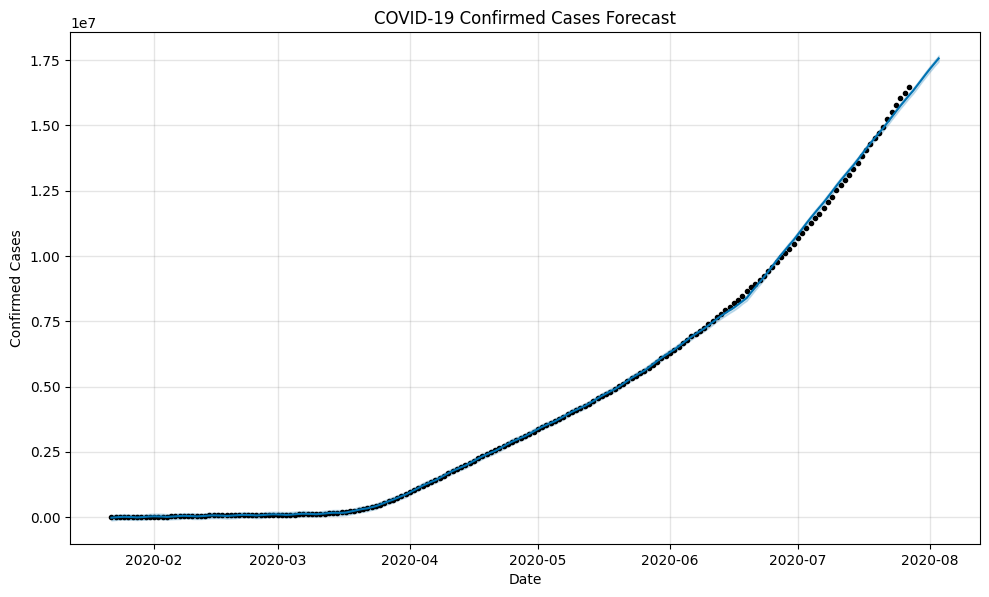

In [260]:
# Visualize the confirmed cases forecasts
model.plot(forecast)
plt.title('COVID-19 Confirmed Cases Forecast')
plt.xlabel('Date')
plt.ylabel('Confirmed Cases')
plt.show()

**Inference: The dots in the above line shows the actual values. The Blue line shows the forecasted values. We can see that the blue line overlaps the actual values most of the times and extends outwards following the same trajectory for the last 7 day forecast period. This suggests that the model is working well.**

**Similarly, Now lets model for Recovered, Active and death cases and forecast for the next 7 days.**

In [261]:
# Recovered Cases modelling and forecasting
model = Prophet()
model.fit(df_recovered)
future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)
forecast.tail(9)
forecast_next_7_days = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)
forecast_next_7_days



INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
188,2020-07-28,9.311038e+06,9.230643e+06,9.396257e+06
189,2020-07-29,9.453140e+06,9.371401e+06,9.533250e+06
190,2020-07-30,9.595793e+06,9.523533e+06,9.673979e+06
191,2020-07-31,9.737193e+06,9.656706e+06,9.815484e+06
192,2020-08-01,9.877354e+06,9.798876e+06,9.958365e+06
193,2020-08-02,1.000333e+07,9.917062e+06,1.008473e+07
194,2020-08-03,1.013983e+07,1.005261e+07,1.021994e+07


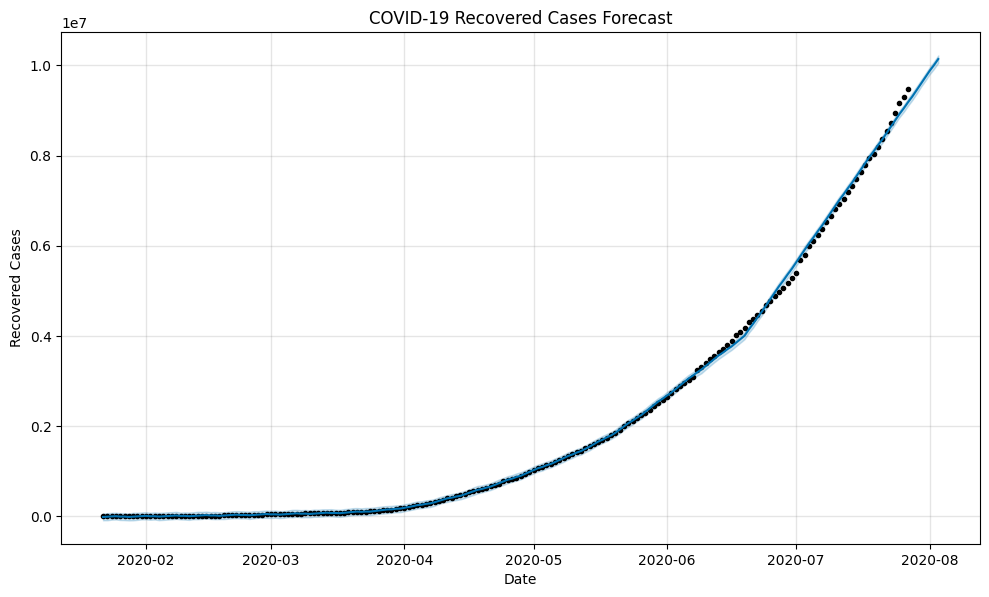

In [262]:
# Visualize the Recovered cases forecasts
model.plot(forecast)
plt.title('COVID-19 Recovered Cases Forecast')
plt.xlabel('Date')
plt.ylabel('Recovered Cases')
plt.show()

In [263]:
# Active Cases modelling and forecasting
model = Prophet()
model.fit(df_active)
future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)
forecast.tail(9)
forecast_next_7_days = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)
forecast_next_7_days


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
188,2020-07-28,6.353420e+06,6.307180e+06,6.398723e+06
189,2020-07-29,6.415820e+06,6.370681e+06,6.462250e+06
190,2020-07-30,6.481279e+06,6.435232e+06,6.530438e+06
191,2020-07-31,6.549320e+06,6.502863e+06,6.598048e+06
192,2020-08-01,6.611485e+06,6.567245e+06,6.659705e+06
193,2020-08-02,6.678776e+06,6.629049e+06,6.727678e+06
194,2020-08-03,6.732526e+06,6.681527e+06,6.781214e+06


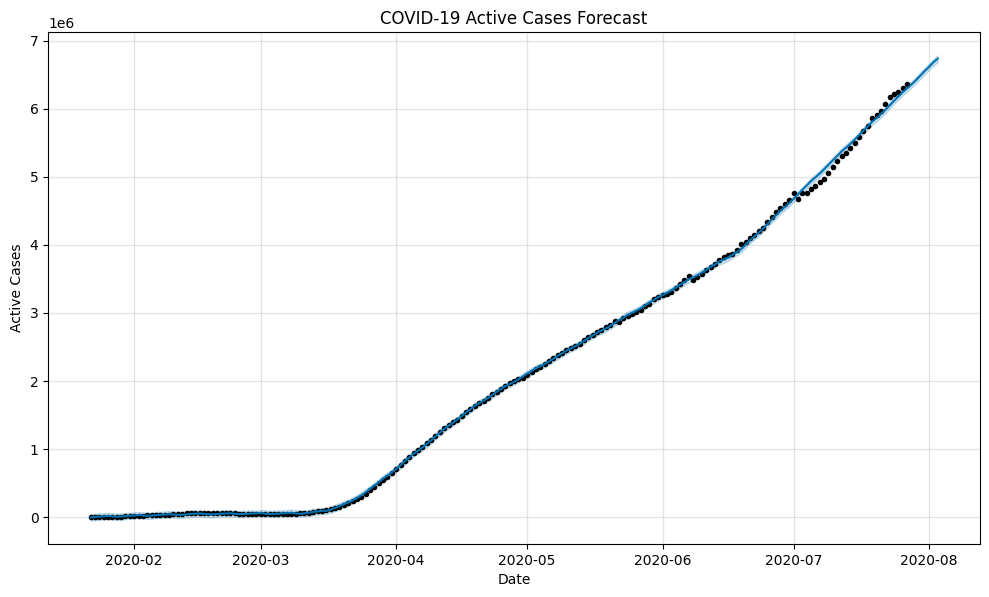

In [264]:
# Visualize the active cases forecasts
model.plot(forecast)
plt.title('COVID-19 Active Cases Forecast')
plt.xlabel('Date')
plt.ylabel('Active Cases')
plt.show()

In [265]:
# Death Cases modelling and forecasting
model = Prophet()
model.fit(df_deaths)
future = model.make_future_dataframe(periods=7)
forecast = model.predict(future)
forecast.tail(9)
forecast_next_7_days = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(7)
forecast_next_7_days

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
188,2020-07-28,652315.573266,650474.080860,654489.914206
189,2020-07-29,657882.137569,655775.989849,659830.676602
190,2020-07-30,663491.406328,661486.341445,665621.018662
191,2020-07-31,669006.407283,666899.285046,671238.791904
192,2020-08-01,673888.441609,671632.388148,676451.248513
193,2020-08-02,678025.360624,675506.736709,680574.356900
194,2020-08-03,682315.675746,679593.953653,685387.742774


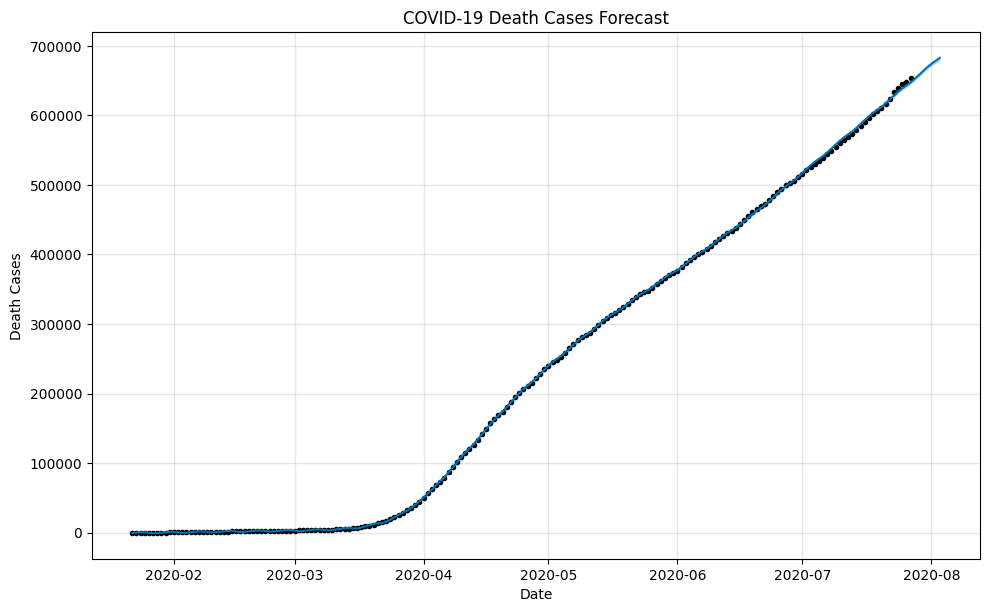

In [266]:
# Visualize the death cases forecasts
model.plot(forecast)
plt.title('COVID-19 Death Cases Forecast')
plt.xlabel('Date')
plt.ylabel('Death Cases')
plt.show()